# Topic Modeling using LDA, NMF and Gensim

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation,NMF
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
import re
import string

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
# Load datasets
def load_data(dataset_path):
    df = pd.read_csv(dataset_path)
    df.drop(columns=['ID'],inplace=True)
    print("Number of records:",len(df))
    print("Null Values:\n",df.isnull().sum())
    return df

In [4]:
# Train data
df_train = load_data(r'/kaggle/input/topic-modeling-for-research-articles/train.csv')
df_train.head()

Number of records: 20972
Null Values:
 TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64


,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


# Exploratory Data Analysis (EDA)

**Topic Distribution for Research Papers**

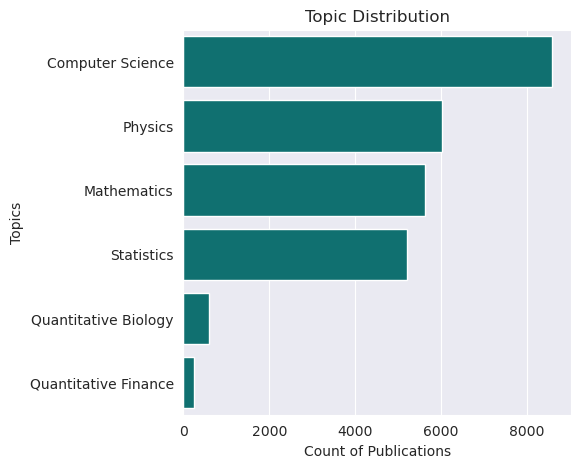

In [5]:
total_counts = df_train[['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']].sum(axis=0)
fig = plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
ax = sns.barplot(x=total_counts.values,y=total_counts.index,color='teal')
ax.set_title('Topic Distribution')
ax.set_xlabel('Count of Publications')
ax.set_ylabel('Topics')
plt.show()

Quantitative Biology and Quantitative Finance can be dropped because of extremely low representation

**Research Publications catering to more than 1 topic**

In [6]:
df_topic = df_train.copy()
col_list = ['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']
df_topic['Total_Topics'] = df_topic.loc[:,col_list].sum(axis=1)
df_topic.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Total_Topics
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,1
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,1
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,1
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,1
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,2


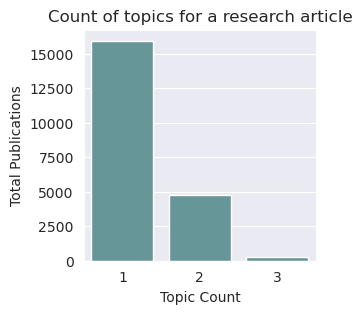

In [52]:
count = df_topic['Total_Topics'].value_counts()
fig = plt.figure(figsize=(3,3))
ax = sns.barplot(x=count.index,y=count.values,color='cadetblue')
ax.set_title('Count of topics for a research article')
ax.set_xlabel('Topic Count')
ax.set_ylabel('Total Publications')
plt.show()

Majority of publications (>15000) have only one topic describing their research publication.

# Data Pre-processing

In [8]:
# Function to concatenate title and abstract columns in the dataframe
def modify_columns(df):
    # Combine columns Title and Abstract
    df['Text'] = df['TITLE'] + ": "+df['ABSTRACT']
    # Drop Quantitative Biology and Quantitative Finance
    df.drop(columns=['Quantitative Biology','Quantitative Finance'],axis=1,inplace=True)
    return df

In [9]:
# Function to preprocess text
def preprocess_text(text):
    # Remove \n from text
    text = re.sub(r'\n',' ',text)
    # Insert space for hyphens
    text = re.sub(r'-',' ',text)
    # Convert to string
    text = str(text)
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^\w ]+',' ',text)
    # Remove punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    # Remove digits
    text = re.sub(r'[\d]+','',text)
    # Remove multiple spaces
    text = ' '.join(text.split())
    # Remove single letters
    text = ' '.join(word for word in text.split() if len(word) > 1)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

In [10]:
# Process train data
df_train = modify_columns(df_train)
df_train_copy = df_train.copy()
df_train_copy.loc[:,'Text'] = df_train_copy['Text'].apply(lambda x:preprocess_text(x)) 
df_train_copy.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Text
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,reconstructing subject specific effect map pre...
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,rotation invariance neural network rotation in...
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,spherical polyharmonics and poisson kernel for...
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,finite element approximation for the stochasti...
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,comparative study of discrete wavelet transfor...


# Latent Dirichlet Allocation : LDA

**TF-IDF**

In [11]:
# Transform documents into Tfidf counts

vectorizer = TfidfVectorizer(max_features=45000,stop_words='english')
dtm = vectorizer.fit_transform(df_train_copy['Text'])
dtm.shape

(20972, 45000)

**Identifying Topics and Top Words**

In [12]:
# Fit LDA on the document-term matrix

lda = LatentDirichletAllocation(n_components=4,random_state=42)
lda.fit_transform(dtm)

array([[0.02947351, 0.02728984, 0.0481026 , 0.89513405],
       [0.04645027, 0.04536649, 0.04899225, 0.85919099],
       [0.04814596, 0.04804005, 0.85184943, 0.05196455],
       ...,
       [0.23766395, 0.03392081, 0.03512365, 0.6932916 ],
       [0.03233638, 0.0315699 , 0.07555605, 0.86053767],
       [0.05831132, 0.04269981, 0.0437374 , 0.85525147]])

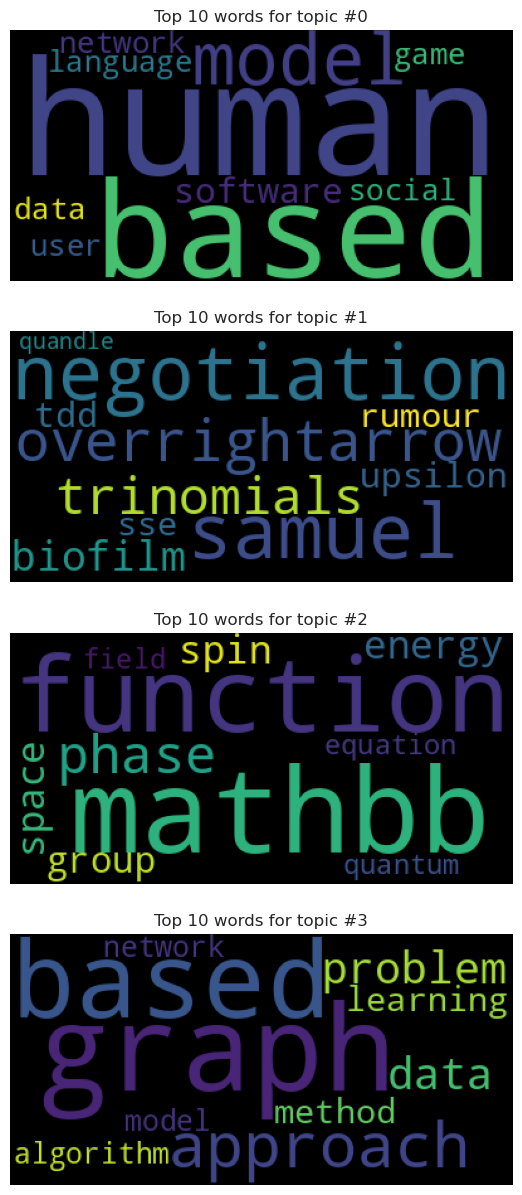

In [13]:
# WordCloud depiction for top 10 words per topic

fig,ax = plt.subplots(4,1,figsize=(25,15))
for index,topic in enumerate(lda.components_):
    words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    wordcloud = WordCloud().generate(' '.join(words))
    ax[index].imshow(wordcloud)
    ax[index].set_title(f"Top 10 words for topic #{index}")
    ax[index].axis('off')

In [14]:
# Topics from LDA
topic_results = lda.fit_transform(dtm)
lda_topics = np.argmax(topic_results,axis=1)
lda_topics

array([3, 3, 2, ..., 3, 3, 3])

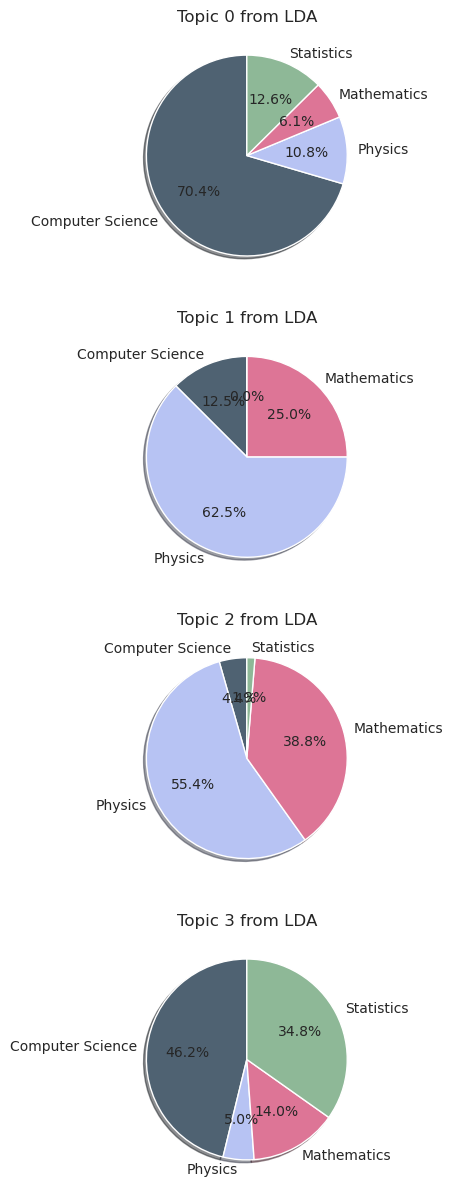

In [15]:
# Filtering our train dataframe as per different lda_topics

cols = df_train_copy.select_dtypes(include=np.number).columns.tolist()
colors_list = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']
fig,ax = plt.subplots(4,1,figsize=(15,15))
for i in range(len(list(set(lda_topics.tolist())))):
    df_train_copy.loc[np.where(lda_topics == i)[0].tolist(),cols].sum(axis=0).plot(kind='pie',
                                                                              autopct='%1.1f%%',
                                                                              startangle=90,
                                                                              shadow=True,
                                                                              colors=colors_list,
                                                                              ax=ax[i])
    ax[i].set_title('Topic '+str(i)+ ' from LDA')

**Prediction on test set**

In [16]:
# Loading test set
df_test = load_data(r'/kaggle/input/topic-modeling-for-research-articles/test.csv')
df_test.head()

Number of records: 8989
Null Values:
 TITLE       0
ABSTRACT    0
dtype: int64


,TITLE,ABSTRACT
0,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [17]:
# Combine columns Title and Abstract
df_test['Text'] = df_test['TITLE'] + ": "+df_test['ABSTRACT']
df_test.head()

,TITLE,ABSTRACT,Text
0,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,Closed-form Marginal Likelihood in Gamma-Poiss...
1,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,Laboratory mid-IR spectra of equilibrated and ...
2,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,Case For Static AMSDU Aggregation in WLANs: ...
3,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...,The $Gaia$-ESO Survey: the inner disk intermed...
4,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,Witness-Functions versus Interpretation-Functi...


In [18]:
# Preprocess text
df_test_copy = df_test.copy()
df_test_copy.loc[:,'Text'] = df_test_copy['Text'].apply(lambda x:preprocess_text(x)) 
df_test_copy.head()

,TITLE,ABSTRACT,Text
0,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,closed form marginal likelihood in gamma poiss...
1,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,laboratory mid ir spectrum of equilibrated and...
2,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,case for static amsdu aggregation in wlan fram...
3,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...,the gaia eso survey the inner disk intermediat...
4,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,witness function versus interpretation functio...


In [19]:
# Vectorize text column using Tfidf
dtm_test = vectorizer.transform(df_test_copy['Text'])
dtm_test.shape

(8989, 45000)

In [20]:
# LDA on the test document-term matrix

test_topics = lda.transform(dtm_test)
test_topics

array([[0.03516229, 0.03411479, 0.03706397, 0.89365894],
       [0.03675503, 0.03599532, 0.89017314, 0.03707651],
       [0.12410855, 0.03790623, 0.03911244, 0.79887278],
       ...,
       [0.04618703, 0.03912984, 0.04029425, 0.87438887],
       [0.03197038, 0.03049591, 0.03172116, 0.90581255],
       [0.05054795, 0.05004928, 0.66418908, 0.23521369]])

In [21]:
# Topics from LDA
lda_test_topics = np.argmax(test_topics,axis=1)
lda_test_topics

array([3, 2, 3, ..., 3, 3, 2])

# Non-Negative Matrix Factorization : NMF

**Identifying topics and top words**

In [22]:
nmf = NMF(n_components=4,max_iter=300,random_state=42)
topic_results_nmf = nmf.fit_transform(dtm)
topic_results_nmf

array([[0.05063914, 0.        , 0.0084776 , 0.00672209],
       [0.        , 0.        , 0.        , 0.08031558],
       [0.00362296, 0.02764024, 0.        , 0.        ],
       ...,
       [0.01260543, 0.00241481, 0.00819777, 0.04434584],
       [0.04442781, 0.0128821 , 0.        , 0.        ],
       [0.01595415, 0.00463179, 0.        , 0.        ]])

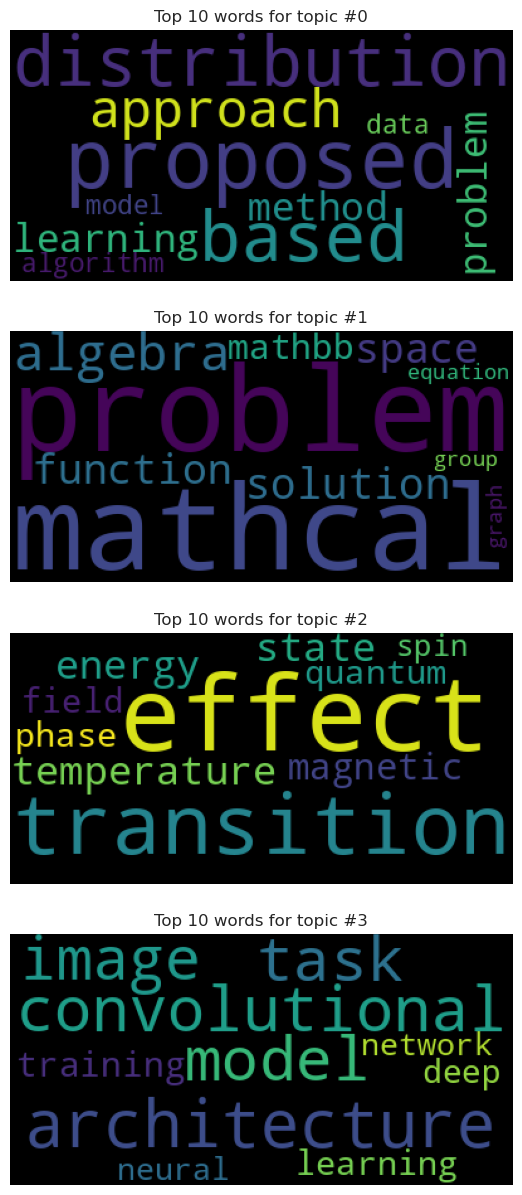

In [23]:
# WordCloud depiction for top 10 words per topic

fig,ax = plt.subplots(4,1,figsize=(25,15))
for index,topic in enumerate(nmf.components_):
    words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    wordcloud = WordCloud().generate(' '.join(words))
    ax[index].imshow(wordcloud)
    ax[index].set_title(f"Top 10 words for topic #{index}")
    ax[index].axis('off')

In [24]:
# Topics from NMF

nmf_topics = np.argmax(topic_results_nmf,axis=1)
nmf_topics

array([0, 3, 1, ..., 3, 0, 0])

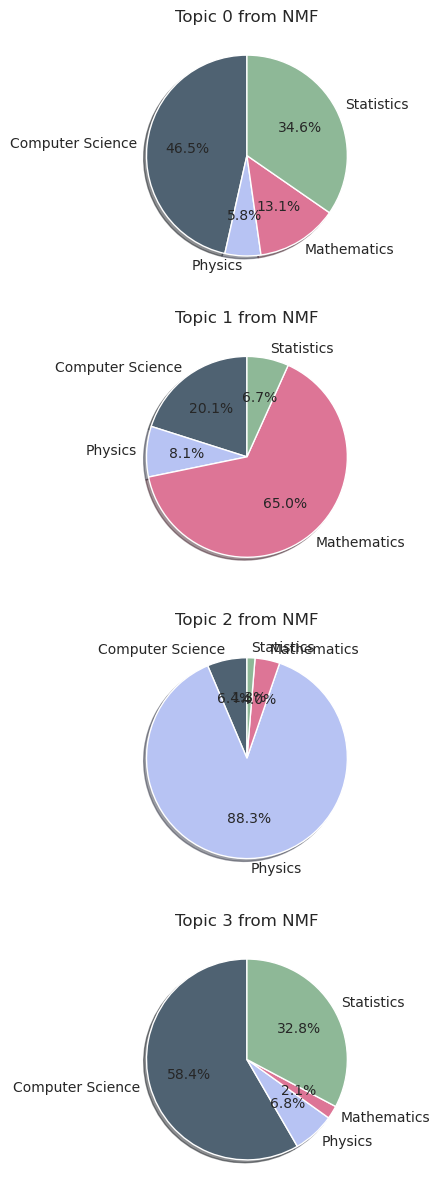

In [25]:
# Filtering our train dataframe as per different nmf topics

cols = df_train_copy.select_dtypes(include=np.number).columns.tolist()
colors_list = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']
fig,ax = plt.subplots(4,1,figsize=(15,15))
for i in range(len(list(set(nmf_topics.tolist())))):
    df_train_copy.loc[np.where(nmf_topics == i)[0].tolist(),cols].sum(axis=0).plot(kind='pie',
                                                                              autopct='%1.1f%%',
                                                                              startangle=90,
                                                                              shadow=True,
                                                                              colors=colors_list,
                                                                              ax=ax[i])
    ax[i].set_title('Topic '+str(i)+ ' from NMF')

**Prediction on Test set**

In [26]:
# NMF on the test document-term matrix

test_topics_nmf = nmf.transform(dtm_test)
test_topics_nmf

array([[0.03850204, 0.01267187, 0.        , 0.        ],
       [0.        , 0.00807223, 0.02252885, 0.00296363],
       [0.02331084, 0.        , 0.00698846, 0.00165516],
       ...,
       [0.02174599, 0.0052504 , 0.01011428, 0.00894358],
       [0.04547613, 0.        , 0.00639896, 0.        ],
       [0.        , 0.02612169, 0.        , 0.00433796]])

In [27]:
# Topics from NMF
nmf_test_topics = np.argmax(test_topics_nmf,axis=1)
nmf_test_topics

array([0, 2, 0, ..., 0, 0, 1])

# Comparison between LDA and NMF on train set

In [28]:
# Extract only the topic columns from train dataframe

df_train_topics = df_train_copy.select_dtypes(include=np.number)
df_train_topics.head()

,Computer Science,Physics,Mathematics,Statistics
0,1,0,0,0
1,1,0,0,0
2,0,0,1,0
3,0,0,1,0
4,1,0,0,1


In [29]:
# Actual topic from train dataframe
train_topics = df_train_topics.idxmax(axis=1)
train_topics

0        Computer Science
1        Computer Science
2             Mathematics
3             Mathematics
4        Computer Science
               ...       
20967    Computer Science
20968             Physics
20969    Computer Science
20970         Mathematics
20971         Mathematics
Length: 20972, dtype: object

In [30]:
# Create dataframe for LDA topics

df_lda_topics = pd.DataFrame(topic_results,
                             columns=['Topic' +str(i) for i in range(len(list(set(lda_topics.tolist()))))])
df_lda_topics['Topic_LDA'] = lda_topics
df_lda_topics.head()

,Topic0,Topic1,Topic2,Topic3,Topic_LDA
0,0.029474,0.027290,0.048103,0.895134,3
1,0.046450,0.045366,0.048992,0.859191,3
2,0.048146,0.048040,0.851849,0.051965,2
3,0.036619,0.036038,0.884034,0.043309,2
4,0.035293,0.034605,0.037031,0.893072,3


In [31]:
# Create dataframe for NMF topics

df_nmf_topics = pd.DataFrame(topic_results_nmf,
                             columns=['Topic' +str(i) for i in range(len(list(set(nmf_topics.tolist()))))])
df_nmf_topics['Topic_NMF'] = nmf_topics
df_nmf_topics.head()

,Topic0,Topic1,Topic2,Topic3,Topic_NMF
0,0.050639,0.000000,0.008478,0.006722,0
1,0.000000,0.000000,0.000000,0.080316,3
2,0.003623,0.027640,0.000000,0.000000,1
3,0.010357,0.054273,0.005742,0.000000,1
4,0.027923,0.000000,0.001671,0.010977,0


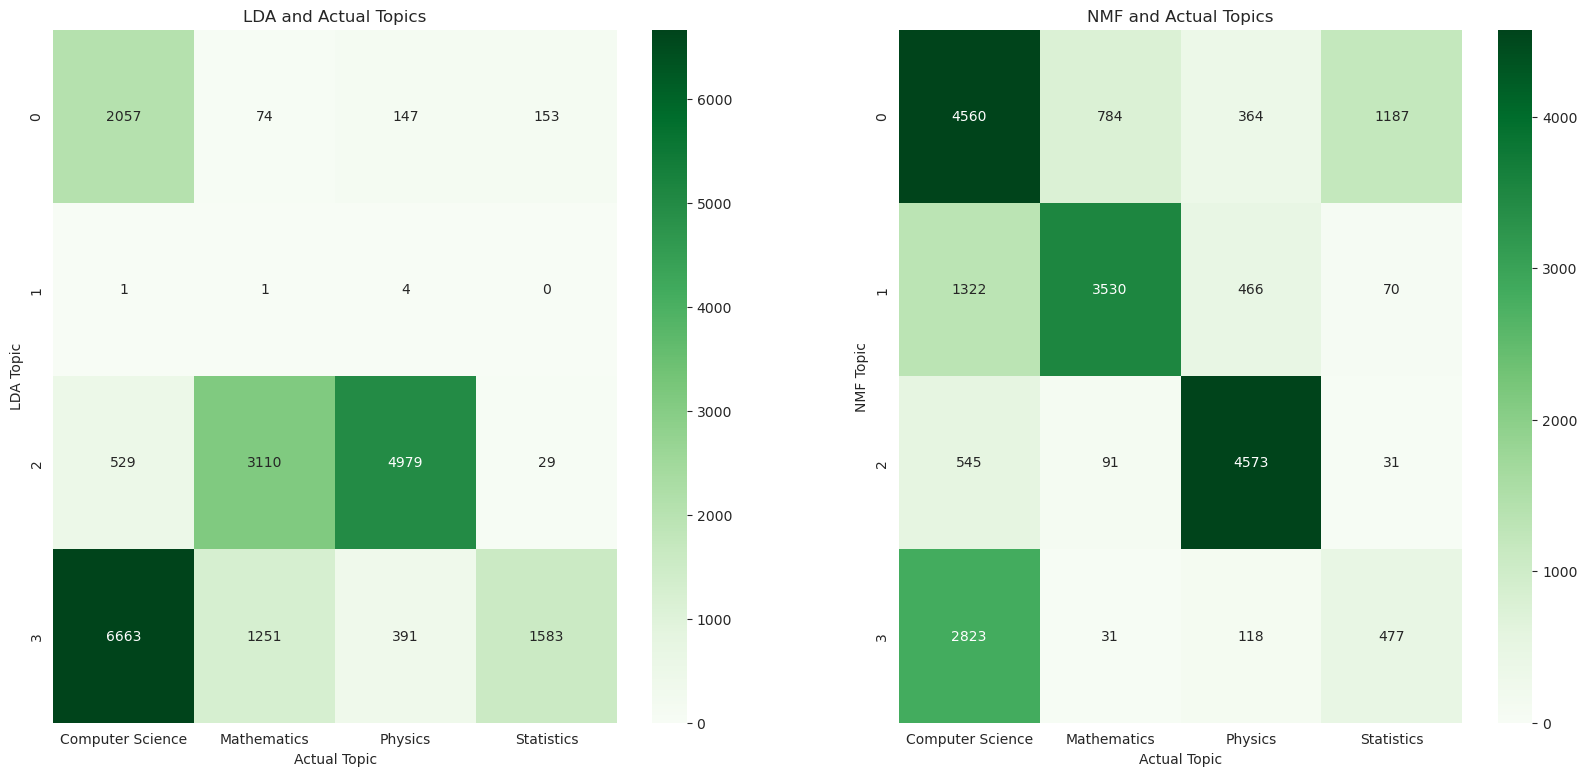

In [32]:
# Crosstab

fig,ax = plt.subplots(1,2,figsize=(20,9))
sns.heatmap(pd.crosstab(df_lda_topics['Topic_LDA'],train_topics),
            annot=True,
            fmt='d',
            cmap='Greens',
            vmin=0,
            ax=ax[0]
           )
ax[0].set_title("LDA and Actual Topics")
ax[0].set_xlabel("Actual Topic")
ax[0].set_ylabel("LDA Topic")

sns.heatmap(pd.crosstab(df_nmf_topics['Topic_NMF'],train_topics),
            annot=True,
            fmt='d',
            cmap='Greens',
            vmin=0,
            ax=ax[1]
           )
ax[1].set_title("NMF and Actual Topics")
ax[1].set_xlabel("Actual Topic")
ax[1].set_ylabel("NMF Topic")
plt.show()

# Topic Modeling with Gensim

In [33]:
import gensim
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Prepare data for topic modeling**

In [34]:
df_train_copy.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Text
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,reconstructing subject specific effect map pre...
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,rotation invariance neural network rotation in...
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,spherical polyharmonics and poisson kernel for...
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,finite element approximation for the stochasti...
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,comparative study of discrete wavelet transfor...


In [35]:
# Removing stopwords
stop_words = set(stopwords.words('english'))

# Tokenize and remove stopwords

def process_text(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Applying preprocessing to text column
text_final = [process_text(text) for text in df_train_copy['Text']]

In [45]:
# Create a dictionary and corpus for text

dictionary = corpora.Dictionary(text_final)

# Filter out words that occur less than 2 documents, or in 100% of the documents.
dictionary.filter_extremes(no_below=2,no_above=1)

# Bag of words representation of the documents
corpus = [dictionary.doc2bow(text) for text in text_final]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 23549
Number of documents: 20972


In [46]:
# Train a LDA model on the corpus

lda_model = gensim.models.LdaModel(corpus=corpus,id2word=dictionary,num_topics=4)

# Print the topics and top words for each topic
for topic in lda_model.show_topics(num_topics=4):
    print('Topic:',topic[0])
    print('Top Words:',topic[1],'\n')

Topic: 0
Top Words: 0.006*"result" + 0.006*"equation" + 0.006*"problem" + 0.006*"function" + 0.006*"show" + 0.006*"space" + 0.005*"two" + 0.005*"system" + 0.005*"state" + 0.005*"field" 

Topic: 1
Top Words: 0.006*"model" + 0.006*"high" + 0.005*"mass" + 0.005*"using" + 0.004*"data" + 0.004*"time" + 0.004*"star" + 0.004*"based" + 0.004*"measurement" + 0.004*"field" 

Topic: 2
Top Words: 0.012*"network" + 0.011*"system" + 0.008*"model" + 0.008*"data" + 0.005*"based" + 0.005*"time" + 0.005*"paper" + 0.004*"user" + 0.004*"using" + 0.004*"information" 

Topic: 3
Top Words: 0.015*"model" + 0.012*"method" + 0.011*"algorithm" + 0.010*"data" + 0.010*"learning" + 0.010*"network" + 0.008*"problem" + 0.007*"based" + 0.007*"approach" + 0.005*"using" 



In [48]:
# Visualize the topics using pyLDAvis

from IPython.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

vis = gensimvis.prepare(lda_model,corpus,dictionary)
pyLDAvis.display(vis)

**Prediction on test set**

In [39]:
df_test_copy.head()

,TITLE,ABSTRACT,Text
0,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,closed form marginal likelihood in gamma poiss...
1,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,laboratory mid ir spectrum of equilibrated and...
2,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,case for static amsdu aggregation in wlan fram...
3,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...,the gaia eso survey the inner disk intermediat...
4,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,witness function versus interpretation functio...


In [40]:
# Applying preprocessing to text column
test_final = [process_text(text) for text in df_test_copy['Text']]

In [49]:
# Create a dictionary and corpus for test set

dictionary_test = corpora.Dictionary(test_final)

# Filter out words that occur less than 2 documents, or in 100% of the documents.
dictionary_test.filter_extremes(no_below=2,no_above=1)

# Bag of words representation of the documents
corpus_test = [dictionary_test.doc2bow(text) for text in test_final]

print('Number of unique tokens: %d' % len(dictionary_test))
print('Number of documents: %d' % len(corpus_test))

Number of unique tokens: 15541
Number of documents: 8989


In [50]:
# Get topics for test set
test_topics_gensim = lda_model.get_document_topics(corpus_test)
topics = []
for i in range(len(corpus_test)):
    item = test_topics_gensim.__getitem__(i)
    topics.append(max(item,key=lambda z:z[1])[0])
        
topics[:10]

[2, 3, 3, 0, 3, 0, 1, 1, 2, 3]

**Thank you for reading !**